<a href="https://colab.research.google.com/github/19522224/CS114.L21/blob/master/scoreprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# **Preprocessor Data**

In [2]:
import pandas as pd
import numpy as np


In [3]:
import sqlite3

conn = sqlite3.connect('Driver={SQL Server};'
                      'Server=RON\SQLEXPRESS;'
                      'Database=TestDB;'
                      'Trusted_Connection=yes;')
cur = conn.cursor()

In [4]:

score=pd.read_excel('./score_training.xlsx')
score.head()

,id,QT,GK,TH,CK,TBM,TBTL
0,22,10,9,8.5,8.5,8.8,8.52
1,24,10,8,10,9.5,9.4,8.41
2,27,10,10,10,10,10,8.67
3,28,10,9.5,7.5,9.5,9.2,7.39
4,29,10,9.5,5,8.5,8.2,8.05


In [5]:
score.to_sql('SCORE', conn, if_exists='replace', index=False)
data_score=pd.DataFrame(cur.execute('SELECT id, CK FROM SCORE  GROUP BY id'))


In [6]:
data_score.rename(columns = {list(data_score)[0]:'user_id'}, inplace=True)
data_score.rename(columns = {list(data_score)[1]:'CK'}, inplace=True)
data_score.head(50)

,user_id,CK
0,22,8.5
1,24,9.5
2,27,10
3,28,9.5
4,29,8.5
5,30,9
6,34,6.5
7,35,4.5
8,36,7
9,37,7.5


In [7]:
wecode=pd.read_excel('./wecode.xlsx')
wecode.head()

,id,assignment_id,problem_id,user_id,is_final,status,pre_score,coefficient,file_name,language_id,created_at,updated_at
0,4,0,3,4,1,SCORE,10000,100,solution-0,2,2020-10-30 10:58:11,2020-10-30 10:58:19
1,5,0,4,4,1,SCORE,10000,100,solution-1,2,2020-10-30 11:07:09,2020-10-30 11:07:17
2,6,0,5,4,0,Compilation Error,0,100,solution-2,2,2020-10-30 11:08:01,2020-10-30 11:23:36
3,7,0,5,4,0,Compilation Error,0,100,solution-3,2,2020-10-30 11:11:41,2020-10-30 11:11:42
4,8,0,5,4,0,Compilation Error,0,100,solution-4,2,2020-10-30 11:15:06,2020-10-30 11:15:07


In [8]:
wecode.describe()
wecode.to_sql('WECODE', conn, if_exists='replace', index=False)

In [9]:
wecode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264606 entries, 0 to 264605
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             264606 non-null  int64         
 1   assignment_id  264606 non-null  int64         
 2   problem_id     264606 non-null  int64         
 3   user_id        264606 non-null  int64         
 4   is_final       264606 non-null  int64         
 5   status         264605 non-null  object        
 6   pre_score      264606 non-null  int64         
 7   coefficient    264606 non-null  object        
 8   file_name      264606 non-null  object        
 9   language_id    264606 non-null  int64         
 10  created_at     264606 non-null  datetime64[ns]
 11  updated_at     264606 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(7), object(3)
memory usage: 24.2+ MB


In [10]:
new_data=pd.DataFrame(cur.execute('SELECT user_id FROM wecode GROUP BY user_id'))
new_data.rename(columns = {list(new_data)[0]:'user_id'}, inplace=True)
new_data.head()

,user_id
0,1
1,4
2,5
3,6
4,7


In [11]:
#1 Tổng số problem đã solved (is_final = 1 && pre_score=10000) / Tổng số problem có submit
new_data['prob_solved/prob_submit']=pd.DataFrame(pd.DataFrame(cur.execute('SELECT COUNT(*) FROM wecode WHERE (is_final = 1 AND pre_score=10000) GROUP BY user_id'))/pd.DataFrame(cur.execute('SELECT COUNT(DISTINCT problem_id)FROM wecode GROUP BY user_id')))
new_data.head()

,user_id,prob_solved/prob_submit
0,1,0.500000
1,4,0.902439
2,5,0.600000
3,6,0.965909
4,7,4.500000


In [12]:
#1.1 Tổng số problem đã solved (is_final = 1 && pre_score=10000)
new_data['prob_solved']=pd.DataFrame(pd.DataFrame(cur.execute('SELECT COUNT(*) FROM wecode WHERE (is_final = 1 AND pre_score=10000) GROUP BY user_id')))
new_data.head()

,user_id,prob_solved/prob_submit,prob_solved
0,1,0.500000,1.0
1,4,0.902439,37.0
2,5,0.600000,3.0
3,6,0.965909,85.0
4,7,4.500000,9.0


In [13]:
#1.2 Tổng số problem có submit
new_data['prob_submit']=pd.DataFrame(pd.DataFrame(cur.execute('SELECT COUNT(DISTINCT problem_id)FROM wecode GROUP BY user_id')))
new_data.head()

,user_id,prob_solved/prob_submit,prob_solved,prob_submit
0,1,0.500000,1.0,2
1,4,0.902439,37.0,41
2,5,0.600000,3.0,5
3,6,0.965909,85.0,88
4,7,4.500000,9.0,2


In [14]:
#2 Tổng số problem đã sumbit / Tổng số submissions 
new_data['prob_sumbit/submissions']=pd.DataFrame(pd.DataFrame(cur.execute('SELECT COUNT(DISTINCT problem_id)FROM wecode GROUP BY user_id'))/pd.DataFrame(cur.execute('SELECT COUNT(*)FROM wecode GROUP BY user_id')))
new_data.head()

,user_id,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions
0,1,0.500000,1.0,2,1.000000
1,4,0.902439,37.0,41,0.759259
2,5,0.600000,3.0,5,0.833333
3,6,0.965909,85.0,88,0.676923
4,7,4.500000,9.0,2,0.400000


In [15]:
#2.1 Tổng số submissions 
new_data['submissions']=pd.DataFrame(pd.DataFrame(cur.execute('SELECT COUNT(*)FROM wecode GROUP BY user_id')))
new_data.head()

,user_id,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions,submissions
0,1,0.500000,1.0,2,1.000000,2
1,4,0.902439,37.0,41,0.759259,54
2,5,0.600000,3.0,5,0.833333,6
3,6,0.965909,85.0,88,0.676923,130
4,7,4.500000,9.0,2,0.400000,5


In [16]:
#3 Số lần submit đúng (pre_score=10000) / tổng số submissions
new_data['right_sumbit/submissions']=pd.DataFrame(pd.DataFrame(cur.execute('SELECT COUNT(*) FROM wecode WHERE pre_score=10000 GROUP BY user_id'))/pd.DataFrame(cur.execute('SELECT COUNT(*)FROM wecode GROUP BY user_id')))
new_data.head()

,user_id,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions,submissions,right_sumbit/submissions
0,1,0.500000,1.0,2,1.000000,2,0.500000
1,4,0.902439,37.0,41,0.759259,54,0.814815
2,5,0.600000,3.0,5,0.833333,6,0.500000
3,6,0.965909,85.0,88,0.676923,130,0.684615
4,7,4.500000,9.0,2,0.400000,5,3.800000


In [17]:
#3.1 Số lần submit đúng (pre_score=10000)
new_data['right_sumbit']=pd.DataFrame(pd.DataFrame(cur.execute('SELECT COUNT(*) FROM wecode WHERE pre_score=10000 GROUP BY user_id')))
new_data.head()

,user_id,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions,submissions,right_sumbit/submissions,right_sumbit
0,1,0.500000,1.0,2,1.000000,2,0.500000,1.0
1,4,0.902439,37.0,41,0.759259,54,0.814815,44.0
2,5,0.600000,3.0,5,0.833333,6,0.500000,3.0
3,6,0.965909,85.0,88,0.676923,130,0.684615,89.0
4,7,4.500000,9.0,2,0.400000,5,3.800000,19.0


In [18]:
#4 Tổng pre_score của các submssion có is_final = 1 
new_data['sum_is_final_1']=pd.DataFrame(cur.execute('SELECT COUNT(*) FROM wecode WHERE is_final = 1 GROUP BY user_id'))
new_data.head()

,user_id,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions,submissions,right_sumbit/submissions,right_sumbit,sum_is_final_1
0,1,0.500000,1.0,2,1.000000,2,0.500000,1.0,2.0
1,4,0.902439,37.0,41,0.759259,54,0.814815,44.0,38.0
2,5,0.600000,3.0,5,0.833333,6,0.500000,3.0,5.0
3,6,0.965909,85.0,88,0.676923,130,0.684615,89.0,88.0
4,7,4.500000,9.0,2,0.400000,5,3.800000,19.0,2.0


In [19]:
#5 Trung bình của Tỷ lệ: problem đã submit/số lượng problem của mỗi assignments

In [20]:
#6 Tổng của max pre_score của mỗi problem_id
new_data['sum_max_scores']=pd.DataFrame(cur.execute('SELECT SUM(max_score) FROM (SELECT user_id, problem_id, MAX(pre_score) AS max_score FROM wecode GROUP BY user_id, problem_id) GROUP BY user_id'))
new_data.head(50)

,user_id,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions,submissions,right_sumbit/submissions,right_sumbit,sum_is_final_1,sum_max_scores
0,1,0.500000,1.0,2,1.000000,2,0.500000,1.0,2.0,10000
1,4,0.902439,37.0,41,0.759259,54,0.814815,44.0,38.0,400000
2,5,0.600000,3.0,5,0.833333,6,0.500000,3.0,5.0,30000
3,6,0.965909,85.0,88,0.676923,130,0.684615,89.0,88.0,850000
4,7,4.500000,9.0,2,0.400000,5,3.800000,19.0,2.0,9209
5,11,0.333333,6.0,18,0.360000,50,0.140000,7.0,12.0,145601
6,14,6.428571,45.0,7,0.318182,22,2.545455,56.0,7.0,68000
7,15,0.240000,12.0,50,0.495050,101,0.118812,12.0,52.0,458666
8,20,6.000000,72.0,12,0.923077,13,6.153846,80.0,12.0,120000
9,24,0.038462,3.0,78,0.475610,164,0.024390,4.0,77.0,760299


In [21]:
new_data=new_data.fillna(0)

In [22]:
#7 trung bình cộng (thời điểm submit cuối cùng - thời điểm submit đầu tiên của mỗi problem)

In [23]:
 new_data=pd.merge(new_data,data_score,on='user_id',how='left')
 new_data.head(50)

,user_id,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions,submissions,right_sumbit/submissions,right_sumbit,sum_is_final_1,sum_max_scores,CK
0,1,0.500000,1.0,2,1.000000,2,0.500000,1.0,2.0,10000,NaN
1,4,0.902439,37.0,41,0.759259,54,0.814815,44.0,38.0,400000,NaN
2,5,0.600000,3.0,5,0.833333,6,0.500000,3.0,5.0,30000,NaN
3,6,0.965909,85.0,88,0.676923,130,0.684615,89.0,88.0,850000,NaN
4,7,4.500000,9.0,2,0.400000,5,3.800000,19.0,2.0,9209,NaN
5,11,0.333333,6.0,18,0.360000,50,0.140000,7.0,12.0,145601,NaN
6,14,6.428571,45.0,7,0.318182,22,2.545455,56.0,7.0,68000,NaN
7,15,0.240000,12.0,50,0.495050,101,0.118812,12.0,52.0,458666,NaN
8,20,6.000000,72.0,12,0.923077,13,6.153846,80.0,12.0,120000,NaN
9,24,0.038462,3.0,78,0.475610,164,0.024390,4.0,77.0,760299,9.5


In [24]:
new_data['CK']=pd.to_numeric(new_data['CK'], errors='coerce')
new_data.head(50)

,user_id,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions,submissions,right_sumbit/submissions,right_sumbit,sum_is_final_1,sum_max_scores,CK
0,1,0.500000,1.0,2,1.000000,2,0.500000,1.0,2.0,10000,NaN
1,4,0.902439,37.0,41,0.759259,54,0.814815,44.0,38.0,400000,NaN
2,5,0.600000,3.0,5,0.833333,6,0.500000,3.0,5.0,30000,NaN
3,6,0.965909,85.0,88,0.676923,130,0.684615,89.0,88.0,850000,NaN
4,7,4.500000,9.0,2,0.400000,5,3.800000,19.0,2.0,9209,NaN
5,11,0.333333,6.0,18,0.360000,50,0.140000,7.0,12.0,145601,NaN
6,14,6.428571,45.0,7,0.318182,22,2.545455,56.0,7.0,68000,NaN
7,15,0.240000,12.0,50,0.495050,101,0.118812,12.0,52.0,458666,NaN
8,20,6.000000,72.0,12,0.923077,13,6.153846,80.0,12.0,120000,NaN
9,24,0.038462,3.0,78,0.475610,164,0.024390,4.0,77.0,760299,9.5


In [25]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1158
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   1159 non-null   int64  
 1   prob_solved/prob_submit   1159 non-null   float64
 2   prob_solved               1159 non-null   float64
 3   prob_submit               1159 non-null   int64  
 4   prob_sumbit/submissions   1159 non-null   float64
 5   submissions               1159 non-null   int64  
 6   right_sumbit/submissions  1159 non-null   float64
 7   right_sumbit              1159 non-null   float64
 8   sum_is_final_1            1159 non-null   float64
 9   sum_max_scores            1159 non-null   int64  
 10  CK                        806 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 108.7 KB


In [26]:
Is_notNull_data=new_data[pd.notnull(new_data['CK'])]


In [27]:
### chọn những giá trị có điểm cuối kì
Is_notNull_data.head(806)

,user_id,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions,submissions,right_sumbit/submissions,right_sumbit,sum_is_final_1,sum_max_scores,CK
9,24,0.038462,3.0,78,0.475610,164,0.024390,4.0,77.0,760299,9.5
10,27,14.400000,72.0,5,0.384615,13,5.769231,75.0,5.0,39000,10.0
11,29,0.037500,3.0,80,0.402010,199,0.015075,3.0,80.0,762760,8.5
13,34,1.726190,145.0,84,0.385321,218,0.697248,152.0,84.0,822888,6.5
14,35,0.632653,93.0,147,0.494949,297,0.336700,100.0,151.0,1437000,4.5
...,...,...,...,...,...,...,...,...,...,...,...
1151,1856,0.000000,0.0,31,0.484375,64,0.000000,0.0,30.0,270790,7.5
1152,1857,0.000000,0.0,34,0.618182,55,0.000000,0.0,48.0,337000,4.0
1153,1859,0.000000,0.0,27,0.870968,31,0.000000,0.0,6.0,39000,1.5
1155,1862,0.000000,0.0,6,0.500000,12,0.000000,0.0,17.0,40000,7.5


In [28]:
### chọn giá trị không có điểm cuối kì
Is_Null_data=new_data[pd.isnull(new_data['CK'])]

In [29]:
Is_Null_data.head()

,user_id,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions,submissions,right_sumbit/submissions,right_sumbit,sum_is_final_1,sum_max_scores,CK
0,1,0.500000,1.0,2,1.000000,2,0.500000,1.0,2.0,10000,NaN
1,4,0.902439,37.0,41,0.759259,54,0.814815,44.0,38.0,400000,NaN
2,5,0.600000,3.0,5,0.833333,6,0.500000,3.0,5.0,30000,NaN
3,6,0.965909,85.0,88,0.676923,130,0.684615,89.0,88.0,850000,NaN
4,7,4.500000,9.0,2,0.400000,5,3.800000,19.0,2.0,9209,NaN


# **Train Model**

## **Import Libraries**

In [30]:

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## **X*Log(X)**

In [31]:
X=Is_notNull_data.drop(['user_id','CK'],axis=1)
y=Is_notNull_data['CK']

In [32]:
import math

def x_log_(x):
  return np.log(x)

In [33]:
data_log = X

In [34]:
data_log['prob_solved/prob_submit']= x_log_(new_data['prob_solved/prob_submit'])
data_log['prob_solved']= x_log_(new_data['prob_solved'])
data_log['prob_submit']= x_log_(new_data['prob_submit'])
data_log['prob_sumbit/submissions']= x_log_(new_data['prob_sumbit/submissions'])
data_log['submissions']= x_log_(new_data['submissions'])
data_log['right_sumbit/submissions']= x_log_(new_data['right_sumbit/submissions'])
data_log['right_sumbit']= x_log_(new_data['right_sumbit'])
data_log['sum_is_final_1']= x_log_(new_data['sum_is_final_1'])
data_log['sum_max_scores']= x_log_(new_data['sum_max_scores'])
data_log.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions,submissions,right_sumbit/submissions,right_sumbit,sum_is_final_1,sum_max_scores
9,-3.258097,1.098612,4.356709,-0.743158,5.099866,-3.713572,1.386294,4.343805,13.541467
10,2.667228,4.276666,1.609438,-0.955511,2.564949,1.752539,4.317488,1.609438,10.571317
11,-3.283414,1.098612,4.382027,-0.911278,5.293305,-4.194693,1.098612,4.382027,13.544699
13,0.545917,4.976734,4.430817,-0.953678,5.384495,-0.360615,5.023881,4.430817,13.620575
14,-0.457833,4.532599,4.990433,-0.703300,5.693732,-1.088562,4.605170,5.017280,14.178068


In [35]:
data_log=data_log.fillna(0)

In [36]:
data_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 806 entries, 9 to 1157
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   prob_solved/prob_submit   806 non-null    float64
 1   prob_solved               806 non-null    float64
 2   prob_submit               806 non-null    float64
 3   prob_sumbit/submissions   806 non-null    float64
 4   submissions               806 non-null    float64
 5   right_sumbit/submissions  806 non-null    float64
 6   right_sumbit              806 non-null    float64
 7   sum_is_final_1            806 non-null    float64
 8   sum_max_scores            806 non-null    float64
dtypes: float64(9)
memory usage: 63.0 KB


## **Processing data**

In [37]:
X=Is_notNull_data.drop(['user_id','CK'],axis=1)
y=Is_notNull_data['CK']

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 806 entries, 9 to 1157
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   prob_solved/prob_submit   806 non-null    float64
 1   prob_solved               806 non-null    float64
 2   prob_submit               806 non-null    int64  
 3   prob_sumbit/submissions   806 non-null    float64
 4   submissions               806 non-null    int64  
 5   right_sumbit/submissions  806 non-null    float64
 6   right_sumbit              806 non-null    float64
 7   sum_is_final_1            806 non-null    float64
 8   sum_max_scores            806 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 63.0 KB


In [39]:
X.head()

,prob_solved/prob_submit,prob_solved,prob_submit,prob_sumbit/submissions,submissions,right_sumbit/submissions,right_sumbit,sum_is_final_1,sum_max_scores
9,0.038462,3.0,78,0.475610,164,0.024390,4.0,77.0,760299
10,14.400000,72.0,5,0.384615,13,5.769231,75.0,5.0,39000
11,0.037500,3.0,80,0.402010,199,0.015075,3.0,80.0,762760
13,1.726190,145.0,84,0.385321,218,0.697248,152.0,84.0,822888
14,0.632653,93.0,147,0.494949,297,0.336700,100.0,151.0,1437000


In [40]:
y.head()

9      9.5
10    10.0
11     8.5
13     6.5
14     4.5
Name: CK, dtype: float64

## **Show on graph**

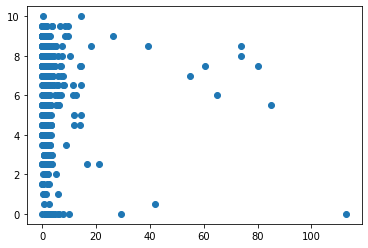

In [41]:
plt.scatter(X['prob_solved/prob_submit'],y)
plt.show()

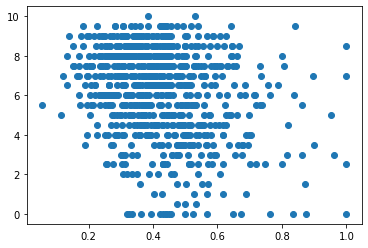

In [42]:
plt.scatter(X['prob_sumbit/submissions'],y)
plt.show()

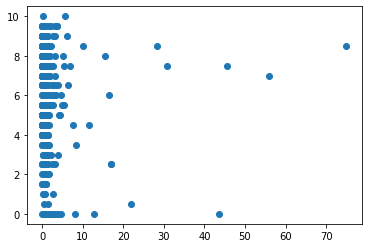

In [43]:
plt.scatter(X['right_sumbit/submissions'],y)

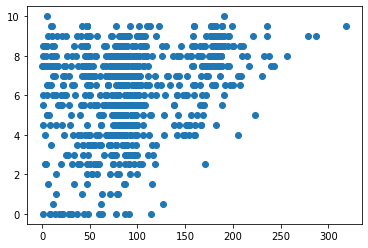

In [44]:
plt.scatter(X['sum_is_final_1'],y)

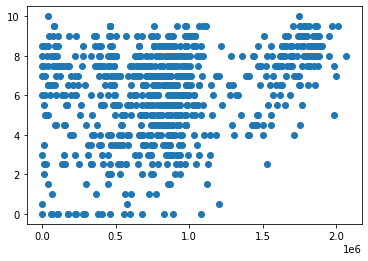

In [45]:
plt.scatter(X['sum_max_scores'],y)

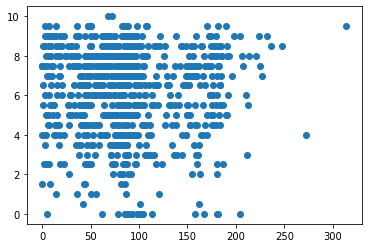

In [46]:
plt.scatter(X['prob_solved'],y)

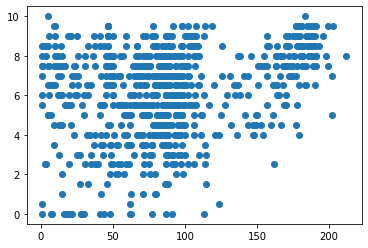

In [47]:
plt.scatter(X['prob_submit'],y)

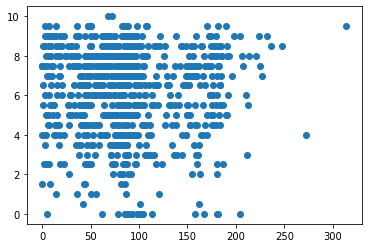

In [48]:
plt.scatter(X['prob_solved'],y)

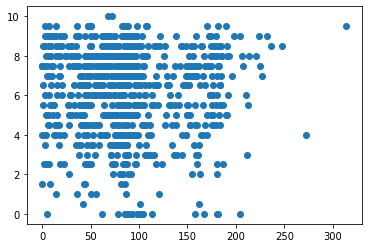

In [49]:
plt.scatter(X['prob_solved'],y)

## Linear Regression

In [163]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [164]:
A=Is_notNull_data[['prob_submit','sum_max_scores','sum_is_final_1']]
A.head()

,prob_submit,sum_max_scores,sum_is_final_1
9,78,760299,77.0
10,5,39000,5.0
11,80,762760,80.0
13,84,822888,84.0
14,147,1437000,151.0


In [165]:
A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 806 entries, 9 to 1157
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   prob_submit     806 non-null    int64  
 1   sum_max_scores  806 non-null    int64  
 2   sum_is_final_1  806 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 25.2 KB


In [166]:
b=Is_notNull_data['CK']
b.head()

9      9.5
10    10.0
11     8.5
13     6.5
14     4.5
Name: CK, dtype: float64

In [167]:
X_train,X_test,y_train,y_test= train_test_split(A,b,test_size=0.2)

In [168]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 644 entries, 471 to 531
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   prob_submit     644 non-null    int64  
 1   sum_max_scores  644 non-null    int64  
 2   sum_is_final_1  644 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 20.1 KB


In [169]:
model=LinearRegression().fit(X_train,y_train)

In [172]:
model.coef_

array([-1.00953449e-01,  1.03834399e-05,  9.11569449e-03])

In [173]:
model.intercept_

5.455846343219404

In [170]:
y_pred=model.predict(X_test)

In [171]:
mean_squared_error(y_pred,y_test)

3.8487260438041857